# Growth of ADP1 ISx Arginine-auxotrophic Strains

In [1]:
from functools import partial

from IPython.display import display, Markdown

from sympy import symbols, Eq, plot, Function, N, Piecewise, solve, latex
from sympy.physics.units.prefixes import micro
from sympy.physics.units import au, gram, liter, milliliter, mol

In [2]:
# numeric rounding to 3 sig figs
N3 = partial(N, n=3)

# additional units
molar = mol / liter
wv_perc = gram / (100 * milliliter)

In [3]:
# symbols (restricted to real values)
Real = partial(symbols, real=True)

# species
CGP, Arg, Asp, prot = Real('CGP, Arg, Asp, prot')

# abundances (mass ratios)
ab_Arg_in_prot = Real(r'abundance_{\frac{Arg}{prot}}')
ab_Arg_in_CGP = Real(r'abundance_{\frac{Arg}{CGP}}')
ab_Asp_in_CGP = Real(r'abundance_{\frac{Asp}{CGP}}')
ab_Arg_in_CDW = Real(r'abundance_{\frac{Arg}{CDW}}')
ab_CGP_in_CDW = Real(r'abundance_{\frac{CGP}{CDW}}')
ab_prot_in_CDW = Real(r'abundance_{\frac{prot}{CDW}}')
ab_CDW_per_OD600 = Real(r'ratio_{\frac{CDW}{OD600}}')

# masses
m_Arg, m_CGP, CDW = Real('m_{Arg}, m_{CGP}, CDW')

# molar weights
mw_Arg, mw_Asp = Real('mw_{Arg}, mw_{Asp}')

# concentrations (molar)
x = Real('x')
x_Arg = Real(r'x_{Arg}')
x_CGP = Real(r'x_{CGP}')

# optical density
OD, OD_initial, OD_delta = Real(r'OD600, OD600_{0}, OD600_{delta}')

# yields
Y_OD_from_x = Real(r'Y_{\frac{OD600}{x}}')
Y_OD_from_Arg_theor = Real(r'Y_{\frac{OD600}{Arg}_{theoretical}}')
Y_OD_from_Arg_exper = Real(r'Y_{\frac{OD600}{Arg}_{experimental}}')
Y_gCDW_from_gArg = Real(r'Y_{\frac{gCDW}{gArg}}')
YF_gCGP_from_gCDW = Real(r'YieldFactor_{\frac{gCGP}{gCDW}}')

# fold change (increase)
fold_chg_biomass = Real('FoldChange_{biomass}')

In [4]:
YF_gCGP_from_gCDW

YieldFactor_{\frac{gCGP}{gCDW}}

In [5]:
# FIXME - differs from Keith's assumptions

consts = {
    # molar weights
    mw_Arg: 174.2 * gram / mol,
    mw_Asp: 133.1 * gram / mol,

    # abundances
    ab_Arg_in_CGP: 0.60,  # FIXME accounting for one H2O loss 174.2 / (174.2 + 133.1 - 18)
    # ab_CGP_in_CDW: 0.10,  # working assumption (previously considered conservative)
    ab_Arg_in_prot: 0.05,  # 1/20 of all proteins (confirmed in cheminfo.ipynb)
    ab_prot_in_CDW: 0.50,  # 1/2 of cell dry weight presumed to be proteins

    # conversions FIXME based on https://bionumbers.hms.harvard.edu/bionumber.aspx?id=109838&ver=2 
    # ab_CDW_per_OD600: .33 * (gram / liter) / au,
    # based on https://link.springer.com/article/10.1007/s00253-019-09910-z 
    ab_CDW_per_OD600: .55 * (gram / liter) / au,
}

In [6]:
# linear relationship between OD600 (optical density) and x (molar concentration)
_eq_OD = Eq(OD, OD_delta + OD_initial)
eq_OD_delta = Eq(OD_delta, x * Y_OD_from_x)
eq_OD = _eq_OD.subs({OD_delta: eq_OD_delta.rhs})

display(_eq_OD, eq_OD_delta, eq_OD)

# print('\n'.join(map(latex, (_eq_OD, eq_OD_delta, eq_OD))))

Eq(OD600, OD600_{0} + OD600_{delta})

Eq(OD600_{delta}, Y_{\frac{OD600}{x}}*x)

Eq(OD600, OD600_{0} + Y_{\frac{OD600}{x}}*x)

In [7]:
_eq_fold_diff = Eq(fold_chg_biomass, (OD_initial + OD_delta) / OD_initial)
eq_fold_diff = Eq(fold_chg_biomass, OD / OD_initial)

display(_eq_fold_diff, eq_fold_diff)

# print('\n'.join(map(latex, (_eq_fold_diff, eq_fold_diff))))

Eq(FoldChange_{biomass}, (OD600_{0} + OD600_{delta})/OD600_{0})

Eq(FoldChange_{biomass}, OD600/OD600_{0})

In [8]:
# Yield in gCDW/gArg

eq_Y_gCDW_from_gArg = Eq(Y_gCDW_from_gArg, Y_OD_from_x * ab_CDW_per_OD600 / mw_Arg)
eq_Y_gCDW_from_gArg

# print(latex(eq_Y_gCDW_from_gArg))

Eq(Y_{\frac{gCDW}{gArg}}, Y_{\frac{OD600}{x}}*ratio_{\frac{CDW}{OD600}}/mw_{Arg})

In [9]:
eq_yf = Eq(YF_gCGP_from_gCDW, x_Arg * mw_Arg / ab_Arg_in_CGP / (OD_delta * ab_CDW_per_OD600))
eq_yf
# print(latex(eq_yf))

Eq(YieldFactor_{\frac{gCGP}{gCDW}}, mw_{Arg}*x_{Arg}/(OD600_{delta}*abundance_{\frac{Arg}{CGP}}*ratio_{\frac{CDW}{OD600}}))

### Theoretical arginine demand by proteome (growth limiting)

This is a theoretical upper bound on arginine-auxotrophic growth, as we expect the highest priority for arginine utilization to be expression of the proteome.

In [10]:
eq_abundance_arg_cdw = Eq(ab_Arg_in_CDW, ab_prot_in_CDW * ab_Arg_in_prot)
consts[ab_Arg_in_CDW] = N3(eq_abundance_arg_cdw.rhs.subs(consts))

# display(eq_abundance_arg_cdw, consts[ab_Arg_in_CDW])
print(latex(eq_abundance_arg_cdw))

abundance_{\frac{Arg}{CDW}} = abundance_{\frac{Arg}{prot}} abundance_{\frac{prot}{CDW}}


In [11]:
eq_Y_OD_from_arg = Eq(Y_OD_from_Arg_theor, mw_Arg / (ab_CDW_per_OD600 * ab_Arg_in_CDW))
_eq_Y_OD_from_arg_theor = N3(eq_Y_OD_from_arg.subs(consts))
consts[Y_OD_from_Arg_theor] = _eq_Y_OD_from_arg_theor.rhs

display(eq_Y_OD_from_arg, _eq_Y_OD_from_arg_theor)
print(latex(eq_Y_OD_from_arg))

Eq(Y_{\frac{OD600}{Arg}_{theoretical}}, mw_{Arg}/(abundance_{\frac{Arg}{CDW}}*ratio_{\frac{CDW}{OD600}}))

Eq(Y_{\frac{OD600}{Arg}_{theoretical}}, 1.27e+4*astronomical_unit*liter/mole)

Y_{\frac{OD600}{Arg}_{theoretical}} = \frac{mw_{Arg}}{abundance_{\frac{Arg}{CDW}} ratio_{\frac{CDW}{OD600}}}


In [12]:
N3(eq_Y_gCDW_from_gArg.subs(consts).subs({Y_OD_from_x: consts[Y_OD_from_Arg_theor]}))

Eq(Y_{\frac{gCDW}{gArg}}, 40.0)

In [13]:
(eq_OD_delta_x_Arg__theor := eq_OD_delta.subs({x: x_Arg, Y_OD_from_x: consts[Y_OD_from_Arg_theor]}))

Eq(OD600_{delta}, 1.27e+4*astronomical_unit*liter*x_{Arg}/mole)

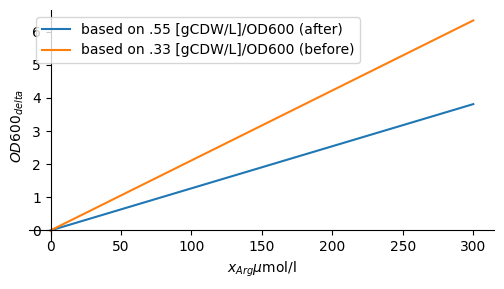

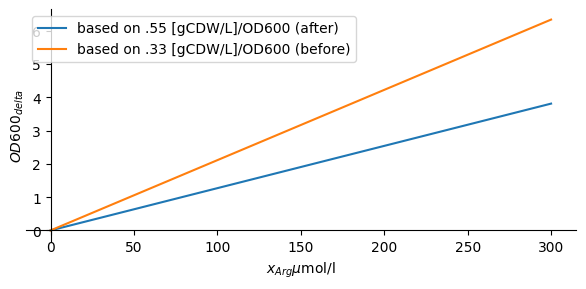

In [14]:
# plot of theoretical OD600 from x_Arg
# NOTE after we changed to .55 gCDW/OD600, the theoretical yield reduced, because we need more arginine to make the same amount of biomass. 
fig_od_cdw = plot(
    # based on the more recent .55 gCDW/OD600 [gCDW/Liter/au] ratio
    eq_OD_delta_x_Arg__theor.rhs.subs(consts) * (micro * mol / liter) / au,
    # based on the older       .33 gCDW/OD600 [gCDW/Liter/au] ratio
    eq_OD_delta.rhs.subs({
        x: x_Arg,
        Y_OD_from_x: eq_Y_OD_from_arg.rhs.subs({ab_CDW_per_OD600: .33 * (gram / liter) / au}),
    }).subs(consts) * (micro * mol / liter) / au,
    (x_Arg, 0, 300),
    xlabel=x_Arg * micro * mol / liter,
    ylabel=OD_delta,
    label=(
        r'based on .55 [gCDW/L]/OD600 (after)',
        r'based on .33 [gCDW/L]/OD600 (before)',
    ),
    legend=True,
    size=(6, 3),
    show=False,
)
fig_od_cdw.save('../../figures/calc_argaux_od_cdw.pdf')
fig_od_cdw.show()

### Accumulated CGP as source of Arginine

ALE Phases with auxotrophic stains:

- Phase I - inoculation from pre-culture, growth and accumulation of CGP
- Phase II - inoculation from cultures from Phase I, growth limited by Arg from 

CGP is accumulated in Phase I and consumed in Phase II of ALE.

### Modeling x_Arg (arginine concentration) in the volume of culture medium

In [15]:
# we know how to estimate OD based on Arg concentration, so we need a function to predict Arg concentration
Function(x_Arg)(OD, ab_CGP_in_CDW)

x_{Arg}(OD600, abundance_{\frac{CGP}{CDW}})

In [16]:
eq_x_Arg_from_OD = Eq(x_Arg, OD * ab_CDW_per_OD600 * ab_CGP_in_CDW * ab_Arg_in_CGP / mw_Arg)
eq_x_Arg_from_OD
latex(eq_x_Arg_from_OD)

'x_{Arg} = \\frac{OD_{600} abundance_{\\frac{Arg}{CGP}} abundance_{\\frac{CGP}{CDW}} ratio_{\\frac{CDW}{OD600}}}{mw_{Arg}}'

In [17]:
eq_OD_of_x_Arg = eq_OD.subs({x: eq_x_Arg_from_OD.rhs.subs({OD: OD_initial})})
eq_fold_chg_biomass = Eq(fold_chg_biomass, (eq_OD_of_x_Arg.rhs / OD_initial).simplify())

display(
    _eq_OD, eq_OD_delta, eq_OD,
    eq_OD,
    eq_OD_of_x_Arg,
    Eq(eq_OD_of_x_Arg.lhs / OD_initial, (eq_OD_of_x_Arg.rhs / OD_initial).simplify()),
    Markdown('---'),
    Markdown('we can conclude that the fold change in not dependent on starting OD'),
    eq_fold_diff,
    eq_fold_chg_biomass,
    N3(eq_fold_chg_biomass.subs(consts)),
    Markdown('fold change depends on the **Yield of OD600 from Arginine** and **CGP (%CDW)**'),
)

# print('\n'.join(map(latex, (eq_OD_of_x_Arg, eq_fold_chg_biomass))))

Eq(OD600, OD600_{0} + OD600_{delta})

Eq(OD600_{delta}, Y_{\frac{OD600}{x}}*x)

Eq(OD600, OD600_{0} + Y_{\frac{OD600}{x}}*x)

Eq(OD600, OD600_{0} + Y_{\frac{OD600}{x}}*x)

Eq(OD600, OD600_{0}*Y_{\frac{OD600}{x}}*abundance_{\frac{Arg}{CGP}}*abundance_{\frac{CGP}{CDW}}*ratio_{\frac{CDW}{OD600}}/mw_{Arg} + OD600_{0})

Eq(OD600/OD600_{0}, (Y_{\frac{OD600}{x}}*abundance_{\frac{Arg}{CGP}}*abundance_{\frac{CGP}{CDW}}*ratio_{\frac{CDW}{OD600}} + mw_{Arg})/mw_{Arg})

---

we can conclude that the fold change in not dependent on starting OD

Eq(FoldChange_{biomass}, OD600/OD600_{0})

Eq(FoldChange_{biomass}, (Y_{\frac{OD600}{x}}*abundance_{\frac{Arg}{CGP}}*abundance_{\frac{CGP}{CDW}}*ratio_{\frac{CDW}{OD600}} + mw_{Arg})/mw_{Arg})

Eq(FoldChange_{biomass}, 0.00574*mole*(174.0*gram/mole + 0.33*gram*Y_{\frac{OD600}{x}}*abundance_{\frac{CGP}{CDW}}/(astronomical_unit*liter))/gram)

fold change depends on the **Yield of OD600 from Arginine** and **CGP (%CDW)**

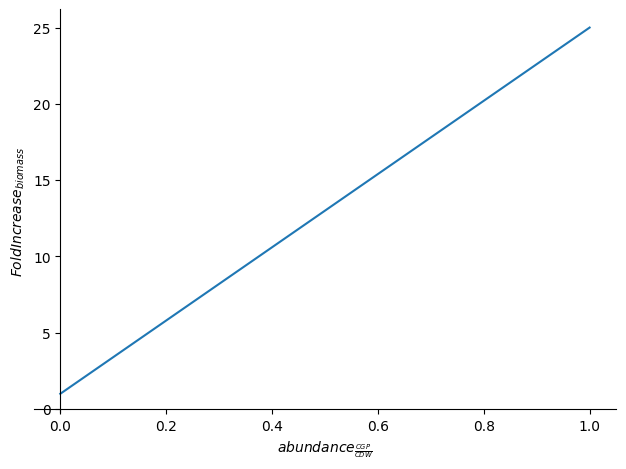

In [18]:
# plot FoldChange_OD600 over CGP(%CDW) :: should be equivalent to Keith's gCDW, since linearly related
plot(
    eq_fold_chg_biomass.rhs.subs({Y_OD_from_x: consts[Y_OD_from_Arg_theor]}).subs(consts),
    (ab_CGP_in_CDW, 0, 1),
    ylabel=symbols('FoldIncrease_{biomass}'),
)

### Experimental Results

In [19]:
# exp007 - ∆argBR ∆astA
N3(eq_OD_delta_x_Arg__exp007_KSF230 := Eq(OD_delta, .976 / 2000 * x_Arg))

Eq(OD600_{delta}, 0.000488*x_{Arg})

In [20]:
# exp008 - KSF107+ {∆argB ∆astA ∆cphAI} 
N3(eq_OD_delta_x_Arg__exp008_KSF107 := Eq(OD_delta, Piecewise(
    # pre-saturation
    (.174 / 50 * x_Arg, x_Arg <= 50),
    # post-saturation
    (.174, x_Arg > 50),
)))

Eq(OD600_{delta}, Piecewise((0.00348*x_{Arg}, x_{Arg} <= 50), (0.174, True)))

In [21]:
# exp011 - ∆argBR ∆astA ∆cphAI
Y_OD_from_Arg_exp011_KSF111 = .446 / 50 * 1e6 * au * liter / mol

N3(eq_OD_delta_x_Arg__exp011_KSF111 := Eq(OD_delta, Piecewise(
    # pre-saturation
    (Y_OD_from_Arg_exp011_KSF111 * 1e-6 * mol / au / liter * x_Arg, x_Arg <= 50),
    # post-saturation
    (.446, x_Arg > 50),
)))

display(
    Eq(Y_OD_from_Arg_exper, Y_OD_from_Arg_exp011_KSF111),
    N3(eq_Y_gCDW_from_gArg.subs(consts).subs({Y_OD_from_x: Y_OD_from_Arg_exp011_KSF111})),
)

Eq(Y_{\frac{OD600}{Arg}_{experimental}}, 8920.0*astronomical_unit*liter/mole)

Eq(Y_{\frac{gCDW}{gArg}}, 28.2)

In [22]:
# exp011 - KSF001 wild-type
N3(eq_OD_delta_x_Arg__exp011_KSF001 := Eq(OD_delta, .428 / 300 * x_Arg))

Eq(OD600_{delta}, 0.00143*x_{Arg})

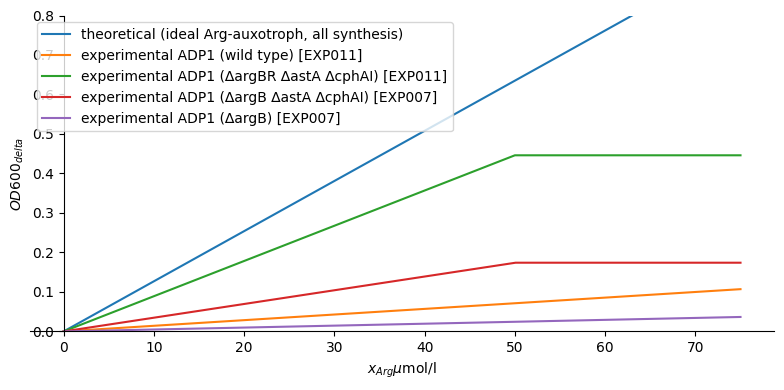

In [23]:
plot(
    # theoretical
    eq_OD_delta_x_Arg__theor.subs(consts).rhs * (micro * mol / liter) / au,
    # exp011
    eq_OD_delta_x_Arg__exp011_KSF001.rhs,  # KSF001 - wild-type
    eq_OD_delta_x_Arg__exp011_KSF111.rhs,  # KSF111 - ∆argBR ∆astA ∆cphAI
    # exp008
    eq_OD_delta_x_Arg__exp008_KSF107.rhs,  # KSF107 - ∆argB ∆astA ∆cphAI
    # exp007 (KSF230 - ∆argB ∆cphAI)
    eq_OD_delta_x_Arg__exp007_KSF230.rhs,  # KSF230 - ∆argB

    # arginine concentration range
    (x_Arg, 0, 75),

    # plot options
    xlabel=x_Arg * micro * mol / liter,
    ylabel=OD_delta,
    ylim=(0, .8),
    label=(
        'theoretical (ideal Arg-auxotroph, all synthesis)',
        'experimental ADP1 (wild type) [EXP011]',
        'experimental ADP1 (∆argBR ∆astA ∆cphAI) [EXP011]',
        'experimental ADP1 (∆argB ∆astA ∆cphAI) [EXP007]',
        'experimental ADP1 (∆argB) [EXP007]',
    ),
    legend=True,
    size=(8, 4),
)

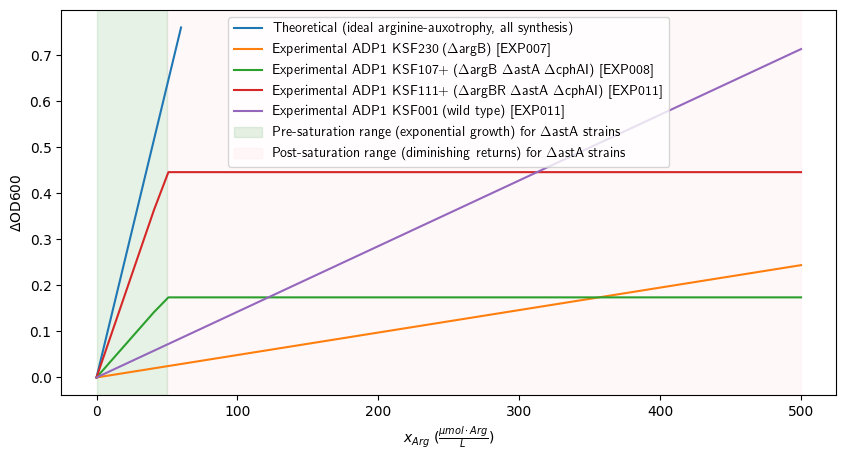

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Define x-axis values for different ranges
x_theor = np.linspace(0, 60, 50)  # Narrower range for theoretical
x_exp = np.linspace(0, 500, 50)  # Wider range for experimental data

# Substitute values and evaluate functions for plotting
y_theor = [eq_OD_delta_x_Arg__theor.subs(consts).rhs.evalf(subs={x_Arg: val}) * (micro * mol / liter) / au for val in
           x_theor]
y_exp_KSF001 = [eq_OD_delta_x_Arg__exp011_KSF001.rhs.evalf(subs={x_Arg: val}) for val in x_exp]
y_exp_KSF111 = [eq_OD_delta_x_Arg__exp011_KSF111.rhs.evalf(subs={x_Arg: val}) for val in x_exp]
y_exp_KSF107 = [eq_OD_delta_x_Arg__exp008_KSF107.rhs.evalf(subs={x_Arg: val}) for val in x_exp]
y_exp_KSF230 = [eq_OD_delta_x_Arg__exp007_KSF230.rhs.evalf(subs={x_Arg: val}) for val in x_exp]

# Plot each curve with its designated range
plt.figure(figsize=(10, 5))
plt.plot(x_theor, y_theor, label='Theoretical (ideal arginine-auxotrophy, all synthesis)')
plt.plot(x_exp, y_exp_KSF230, label=r'Experimental ADP1 KSF230  ($\Delta$argB) [EXP007]')
plt.plot(x_exp, y_exp_KSF107, label=r'Experimental ADP1 KSF107+ ($\Delta$argB  $\Delta$astA $\Delta$cphAI) [EXP008]')
plt.plot(x_exp, y_exp_KSF111, label=r'Experimental ADP1 KSF111+ ($\Delta$argBR $\Delta$astA $\Delta$cphAI) [EXP011]')
plt.plot(x_exp, y_exp_KSF001, label=r'Experimental ADP1 KSF001  (wild type) [EXP011]')

plt.axvspan(.1, 50, color='green', alpha=0.1, label=r'Pre-saturation range (exponential growth) for $\Delta$astA strains')
plt.axvspan(50, 500, color='pink', alpha=0.1, label=r'Post-saturation range (diminishing returns) for $\Delta$astA strains')

# Set labels, legend, and show plot
plt.rcParams['text.usetex'] = True
plt.xlabel(r"$x_{Arg}$ ($\frac{\mu mol \cdot Arg}{L}$)")
plt.ylabel(r"$\Delta$OD600")
plt.legend()

plt.savefig('../../figures/calc_argaux_yields.pdf')

plt.show()

In [25]:
N3(eq_yf.subs(consts).subs({x_Arg: 50e-6 * mol / liter, OD_delta: .45 * au}))

Eq(YieldFactor_{\frac{gCGP}{gCDW}}, 0.0587)

### Designing the ALE POC experiment

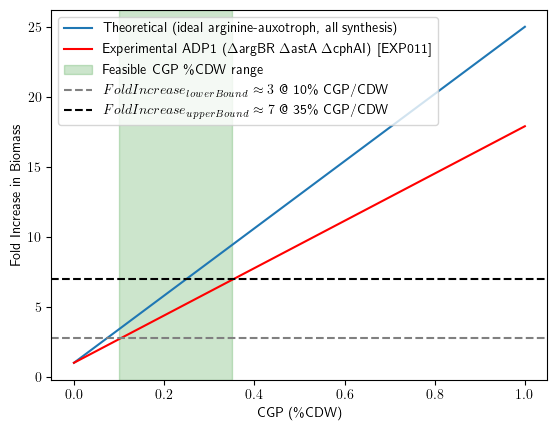

In [26]:
# Generate x-values for the plot
x = np.linspace(0, 1, 100)

# Evaluate the theoretical and experimental curves
y_theoretical = [
    eq_fold_chg_biomass.rhs.subs({Y_OD_from_x: consts[Y_OD_from_Arg_theor]}).subs(consts).subs({ab_CGP_in_CDW: xi})
    for xi in x
]
y_experimental = [
    eq_fold_chg_biomass.rhs.subs({Y_OD_from_x: Y_OD_from_Arg_exp011_KSF111}).subs(consts).subs({ab_CGP_in_CDW: xi})
    for xi in x
]

# Plot the data
plt.plot(x, y_theoretical, label=r'Theoretical (ideal arginine-auxotroph, all synthesis)')
plt.plot(x, y_experimental, label=r'Experimental ADP1 ($\Delta$argBR $\Delta$astA $\Delta$cphAI) [EXP011]', color='red')

# Add the vertical span
plt.axvspan(0.1, 0.35, color='green', alpha=0.2, label=r'Feasible CGP \%CDW range')
plt.axhline(2.8, color='gray', linestyle='--', label=r'$FoldIncrease_{lowerBound} \approx 3$ @ 10\% CGP/CDW')
plt.axhline(7, color='black', linestyle='--', label=r'$FoldIncrease_{upperBound} \approx 7$ @ 35\% CGP/CDW')

# Add labels, legend, and title
plt.xlabel(r'CGP (\%CDW)')
plt.ylabel(r'Fold Increase in Biomass')
plt.legend()
# plt.title('Theoretical vs Experimental Fold Change in Biomass')

plt.savefig('../../figures/calc_argaux_foldchange.pdf')

# Show the plot
plt.show()

In [27]:
# fig_fold_changes = plot(
#     # theoretical
#     eq_fold_chg_biomass.rhs.subs({Y_OD_from_x: consts[Y_OD_from_Arg_theor]}).subs(consts),
#     # KSF011 from exp011
#     eq_fold_chg_biomass.rhs.subs({Y_OD_from_x: Y_OD_from_Arg_exp011_KSF111}).subs(consts),
#     (ab_CGP_in_CDW, 0, 1),
#     ylabel=symbols('FoldIncrease_{biomass}'),
#     legend=True,
#     label=(
#         r'theoretical (ideal arginine-auxotroph, all synthesis)',
#         r'experimental ADP1 ($\Delta$argBR $\Delta$astA $\Delta$cphAI) [EXP011]',
#     ),
# )

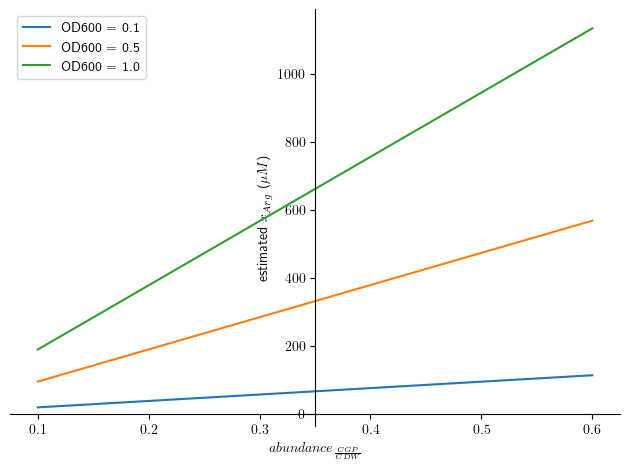

In [28]:
# proposed loading (need much higher starting OD of .1 au if we assume the most conservative 10% CGP.
# FIXME this is where we really need a good model and assumptions for x_Arg from cells with CGP
plot(
    N3(eq_x_Arg_from_OD.rhs.subs({OD: .1 * au}).subs(consts) * 1e6 * liter / mol),
    N3(eq_x_Arg_from_OD.rhs.subs({OD: .5 * au}).subs(consts) * 1e6 * liter / mol),
    N3(eq_x_Arg_from_OD.rhs.subs({OD: 1 * au}).subs(consts) * 1e6 * liter / mol),
    (ab_CGP_in_CDW, .1, .6),
    xlabel=ab_CGP_in_CDW,
    ylabel=r'estimated $x_{Arg}$ ($\mu M$)',
    label=(r'OD600 = 0.1', r'OD600 = 0.5', r'OD600 = 1.0'),
    legend=True,
)

In [29]:
# fold change KSF111 + ∆astB
display(
    eq_fold_chg_biomass.rhs.subs({Y_OD_from_x: Y_OD_from_Arg_exp011_KSF111}).subs(consts).subs({ab_CGP_in_CDW: 0.10}),
    eq_fold_chg_biomass.rhs.subs({Y_OD_from_x: Y_OD_from_Arg_exp011_KSF111}).subs(consts).subs({ab_CGP_in_CDW: 0.40}),
)

2.68978185993111

7.75912743972446

In [30]:
# 3.5-fold is high enough to proceed with ALE, but I need a better measurement of ab_CGP_in_CDW
display(
    Markdown('experimental OD600 fold increase'),
    solve(eq_fold_diff.subs({OD_initial: .1 * au, fold_chg_biomass: 3.5}), OD / au),
    Markdown('---'),
    Markdown('background OD600 fold increase'),
    solve(eq_fold_diff.subs({OD_initial: .1 * au, fold_chg_biomass: 1.7}), OD / au),
)

experimental OD600 fold increase

[0.350000000000000]

---

background OD600 fold increase

[0.170000000000000]